This notebook creates a summary view of the clustering-based quality of LE embeddings for all data inputs (e.g., real and nullified) across all considered scenarios (e.g., m, knn, dist).

In [1]:
import pandas as pd
import xarray as xr
import numpy as np
import os.path as osp
import os
import hvplot.pandas
import hvplot.xarray
import seaborn as sns
import matplotlib.pyplot as plt
from utils.basics import PRJ_DIR, PNAS2015_subject_list, sbj_cmap_list,sbj_cmap_dict
from utils.basics import le_dist_metrics, le_knns, le_ms
from utils.basics import umap_dist_metrics, umap_knns, umap_ms, umap_alphas, umap_inits
from utils.basics import tsne_dist_metrics, tsne_pps, tsne_ms, tsne_lrs
from utils.basics import task_cmap_caps as task_cmap
from scipy.stats import zscore
import panel as pn
import plotly.express as px
from IPython.display import Image
from tqdm.notebook import tqdm, tqdm_notebook
from utils.plotting import plot_2d_scatter, plot_3d_scatter
from utils.io import load_LE_SI, load_UMAP_SI, load_LE_embeddings, load_UMAP_embeddings

In [2]:
le_knns.remove(5)
le_knns.remove(10)
le_knns.remove(15)

In [3]:
knns_dict = {'LE':le_knns,'TSNE':tsne_pps,'UMAP':umap_knns}
ms_dist   = {'LE':le_ms,'TSNE':tsne_ms, 'UMAP':umap_ms}
lrs_dict  = {'LE':['N/A'],'TSNE':tsne_lrs,'UMAP':umap_alphas}
dists_dict = {'LE':le_dist_metrics,'TSNE':tsne_dist_metrics,'UMAP':umap_dist_metrics}
inits_dict = {'LE':['N/A'],'TSNE':['pca','random'],'UMAP':['spectral']} #'UMAP':['random','spectral']}
techs      = ['LE','TSNE','UMAP']

In [4]:
from sklearn.metrics import silhouette_score
from statannotations.Annotator import Annotator
from scipy.spatial import procrustes

In [5]:
# So far we are working with these values of wls and wss across the whole manuscript
wls = 45
wss = 1.5
min_dist = 0.8
#ms = [2,3]

***
# Laplacian Eigenmap
#### Load Silhouette Index Results for Laplacian Embeddings

In [6]:
%%time
si_LE_all   = load_LE_SI(sbj_list=['ALL'],check_availability=False, verbose=True, wls=wls, wss=wss, input_datas=['Original'])

Final Dimensions:   0%|          | 0/3 [00:00<?, ?it/s]

Distance Metric:   0%|          | 0/3 [00:00<?, ?it/s]

-e "/data/SFIMJGC_HCP7T/manifold_learning_fmri/Data_Interim/PNAS2015/ALL/LE/Original/ALL_Craddock_0200.WL045s.WS1.5s.LE_euclidean_k0020_m0002.asis.SI.pkl" -e "/data/SFIMJGC_HCP7T/manifold_learning_fmri/Data_Interim/PNAS2015/ALL/LE/Original/ALL_Craddock_0200.WL045s.WS1.5s.LE_euclidean_k0025_m0002.asis.SI.pkl" -e "/data/SFIMJGC_HCP7T/manifold_learning_fmri/Data_Interim/PNAS2015/ALL/LE/Original/ALL_Craddock_0200.WL045s.WS1.5s.LE_correlation_k0020_m0002.zscored.SI.pkl" -e "/data/SFIMJGC_HCP7T/manifold_learning_fmri/Data_Interim/PNAS2015/ALL/LE/Original/ALL_Craddock_0200.WL045s.WS1.5s.LE_correlation_k0025_m0002.zscored.SI.pkl" -e "/data/SFIMJGC_HCP7T/manifold_learning_fmri/Data_Interim/PNAS2015/ALL/LE/Original/ALL_Craddock_0200.WL045s.WS1.5s.LE_cosine_k0020_m0002.zscored.SI.pkl" 

Distance Metric:   0%|          | 0/3 [00:00<?, ?it/s]

-e "/data/SFIMJGC_HCP7T/manifold_learning_fmri/Data_Interim/PNAS2015/ALL/LE/Original/ALL_Craddock_0200.WL045s.WS1.5s.LE_cosine_k0020_m0003.zscored.SI.pkl" 

Distance Metric:   0%|          | 0/3 [00:00<?, ?it/s]

++ INFO: Number of files missing: [6/666] files
CPU times: user 3.06 s, sys: 65.7 ms, total: 3.13 s
Wall time: 3.17 s


In [7]:
%%time
si_LE_scans = load_LE_SI(sbj_list=PNAS2015_subject_list,check_availability=False, verbose=True, wls=wls, wss=wss)

Final Dimensions:   0%|          | 0/3 [00:00<?, ?it/s]

Distance Metric:   0%|          | 0/3 [00:00<?, ?it/s]

Distance Metric:   0%|          | 0/3 [00:00<?, ?it/s]

Distance Metric:   0%|          | 0/3 [00:00<?, ?it/s]

++ INFO: Number of files missing: [0/39960] files
CPU times: user 2min 28s, sys: 4.92 s, total: 2min 33s
Wall time: 3min 30s


In [8]:
si_LE = pd.concat([si_LE_scans, si_LE_all])
del si_LE_scans, si_LE_all

#### Load Silhouette Index Results for UMAP

In [9]:
%%time
si_UMAP_scans = load_UMAP_SI(sbj_list=PNAS2015_subject_list,check_availability=False, verbose=True, wls=wls, wss=wss, ms=[2,3],scenarios=['asis'],init_methods=['spectral'])

Final Dimensions:   0%|          | 0/2 [00:00<?, ?it/s]

Distance Metric:   0%|          | 0/3 [00:00<?, ?it/s]

Distance Metric:   0%|          | 0/3 [00:00<?, ?it/s]


++ INFO: Number of missing files = [0/15480] files
CPU times: user 54.4 s, sys: 1.54 s, total: 55.9 s
Wall time: 1min 9s


In [10]:
si_UMAP_all   = load_UMAP_SI(sbj_list=['ALL'],check_availability=False, verbose=True, wls=wls, wss=wss, ms=[2,3],init_methods=['spectral'])

Final Dimensions:   0%|          | 0/2 [00:00<?, ?it/s]

Distance Metric:   0%|          | 0/3 [00:00<?, ?it/s]

-e "/data/SFIMJGC_HCP7T/manifold_learning_fmri/Data_Interim/PNAS2015/ALL/UMAP/ALL_Craddock_0200.WL045s.WS1.5s.UMAP_euclidean_k0002_m0002_md0.8_a0.01_spectral.asis.SI.pkl"
-e "/data/SFIMJGC_HCP7T/manifold_learning_fmri/Data_Interim/PNAS2015/ALL/UMAP/ALL_Craddock_0200.WL045s.WS1.5s.UMAP_euclidean_k0002_m0002_md0.8_a0.1_spectral.asis.SI.pkl"
-e "/data/SFIMJGC_HCP7T/manifold_learning_fmri/Data_Interim/PNAS2015/ALL/UMAP/ALL_Craddock_0200.WL045s.WS1.5s.UMAP_euclidean_k0002_m0002_md0.8_a1.0_spectral.asis.SI.pkl"


Distance Metric:   0%|          | 0/3 [00:00<?, ?it/s]

-e "/data/SFIMJGC_HCP7T/manifold_learning_fmri/Data_Interim/PNAS2015/ALL/UMAP/ALL_Craddock_0200.WL045s.WS1.5s.UMAP_euclidean_k0002_m0003_md0.8_a0.01_spectral.asis.SI.pkl"
-e "/data/SFIMJGC_HCP7T/manifold_learning_fmri/Data_Interim/PNAS2015/ALL/UMAP/ALL_Craddock_0200.WL045s.WS1.5s.UMAP_euclidean_k0002_m0003_md0.8_a0.1_spectral.asis.SI.pkl"
-e "/data/SFIMJGC_HCP7T/manifold_learning_fmri/Data_Interim/PNAS2015/ALL/UMAP/ALL_Craddock_0200.WL045s.WS1.5s.UMAP_euclidean_k0002_m0003_md0.8_a1.0_spectral.asis.SI.pkl"

++ INFO: Number of missing files = [6/1548] files


In [11]:
si_UMAP = pd.concat([si_UMAP_scans, si_UMAP_all])
del si_UMAP_scans, si_UMAP_all

#### Load LE Embeddings

In [12]:
%%time
LE_embs_all = load_LE_embeddings(['ALL'],check_availability=False, verbose=True, wls=wls, wss=wss, input_datas=['Original'])

Final Dimensions:   0%|          | 0/3 [00:00<?, ?it/s]

Distance Metric:   0%|          | 0/3 [00:00<?, ?it/s]

-e "/data/SFIMJGC_HCP7T/manifold_learning_fmri/Data_Interim/PNAS2015/ALL/LE/Original/ALL_Craddock_0200.WL045s.WS1.5s.LE_euclidean_k0020_m0002.asis.pkl"
-e "/data/SFIMJGC_HCP7T/manifold_learning_fmri/Data_Interim/PNAS2015/ALL/LE/Original/ALL_Craddock_0200.WL045s.WS1.5s.LE_euclidean_k0025_m0002.asis.pkl"
-e "/data/SFIMJGC_HCP7T/manifold_learning_fmri/Data_Interim/PNAS2015/ALL/LE/Original/ALL_Craddock_0200.WL045s.WS1.5s.LE_correlation_k0020_m0002.zscored.pkl"
-e "/data/SFIMJGC_HCP7T/manifold_learning_fmri/Data_Interim/PNAS2015/ALL/LE/Original/ALL_Craddock_0200.WL045s.WS1.5s.LE_correlation_k0025_m0002.zscored.pkl"
-e "/data/SFIMJGC_HCP7T/manifold_learning_fmri/Data_Interim/PNAS2015/ALL/LE/Original/ALL_Craddock_0200.WL045s.WS1.5s.LE_cosine_k0020_m0002.zscored.pkl"


Distance Metric:   0%|          | 0/3 [00:00<?, ?it/s]

-e "/data/SFIMJGC_HCP7T/manifold_learning_fmri/Data_Interim/PNAS2015/ALL/LE/Original/ALL_Craddock_0200.WL045s.WS1.5s.LE_cosine_k0020_m0003.zscored.pkl"


Distance Metric:   0%|          | 0/3 [00:00<?, ?it/s]

++ INFO: Number of missing files [6/666]
CPU times: user 3.37 s, sys: 2.79 s, total: 6.16 s
Wall time: 21.1 s


In [13]:
LE_embs_scans = load_LE_embeddings(PNAS2015_subject_list,check_availability=False, verbose=True, wls=wls, wss=wss)

Final Dimensions:   0%|          | 0/3 [00:00<?, ?it/s]

Distance Metric:   0%|          | 0/3 [00:00<?, ?it/s]

Distance Metric:   0%|          | 0/3 [00:00<?, ?it/s]

Distance Metric:   0%|          | 0/3 [00:00<?, ?it/s]

++ INFO: Number of missing files [0/39960]


In [14]:
LE_embs = {**LE_embs_scans, **LE_embs_all}
del LE_embs_scans, LE_embs_all

#### Load UMAP Embeddings

In [8]:
%%time
UMAP_embs_all = load_UMAP_embeddings(['ALL'],check_availability=False, verbose=True, wls=wls, wss=wss, ms=[2,3],init_methods=['spectral'])

Final Dimensions:   0%|          | 0/2 [00:00<?, ?it/s]

Distance Metric:   0%|          | 0/3 [00:00<?, ?it/s]

-e "/data/SFIMJGC_HCP7T/manifold_learning_fmri/Data_Interim/PNAS2015/ALL/UMAP/ALL_Craddock_0200.WL045s.WS1.5s.UMAP_euclidean_k0002_m0002_md0.8_a0.01_spectral.asis.pkl"
-e "/data/SFIMJGC_HCP7T/manifold_learning_fmri/Data_Interim/PNAS2015/ALL/UMAP/ALL_Craddock_0200.WL045s.WS1.5s.UMAP_euclidean_k0002_m0002_md0.8_a0.1_spectral.asis.pkl"
-e "/data/SFIMJGC_HCP7T/manifold_learning_fmri/Data_Interim/PNAS2015/ALL/UMAP/ALL_Craddock_0200.WL045s.WS1.5s.UMAP_euclidean_k0002_m0002_md0.8_a1.0_spectral.asis.pkl"


Distance Metric:   0%|          | 0/3 [00:00<?, ?it/s]

-e "/data/SFIMJGC_HCP7T/manifold_learning_fmri/Data_Interim/PNAS2015/ALL/UMAP/ALL_Craddock_0200.WL045s.WS1.5s.UMAP_euclidean_k0002_m0003_md0.8_a0.01_spectral.asis.pkl"
-e "/data/SFIMJGC_HCP7T/manifold_learning_fmri/Data_Interim/PNAS2015/ALL/UMAP/ALL_Craddock_0200.WL045s.WS1.5s.UMAP_euclidean_k0002_m0003_md0.8_a0.1_spectral.asis.pkl"
-e "/data/SFIMJGC_HCP7T/manifold_learning_fmri/Data_Interim/PNAS2015/ALL/UMAP/ALL_Craddock_0200.WL045s.WS1.5s.UMAP_euclidean_k0002_m0003_md0.8_a1.0_spectral.asis.pkl"

++ INFO: Number of missing files = [6/1548] files
CPU times: user 3.8 s, sys: 553 ms, total: 4.35 s
Wall time: 31.9 s


In [9]:
%%time
UMAP_embs_scans = load_UMAP_embeddings(PNAS2015_subject_list,check_availability=False, verbose=True, wls=wls, wss=wss, ms=[2,3],scenarios=['asis'],init_methods=['spectral'])

Final Dimensions:   0%|          | 0/2 [00:00<?, ?it/s]

Distance Metric:   0%|          | 0/3 [00:00<?, ?it/s]

Distance Metric:   0%|          | 0/3 [00:00<?, ?it/s]


++ INFO: Number of missing files = [0/15480] files
CPU times: user 36 s, sys: 3.6 s, total: 39.6 s
Wall time: 4min 28s


In [10]:
UMAP_embs = {**UMAP_embs_scans, **UMAP_embs_all}
del UMAP_embs_scans, UMAP_embs_all

In [11]:
embs = {'LE': LE_embs, 'UMAP':UMAP_embs}

***
# Panel A. SI for all data types, knn, metrics and m=2,3

The next cell takes ```si_xrs``` and seaborn to plot the evolution of SI across knn for the different metric types and also as a function of whether the input is the original data or data that has been nullified.



In [145]:
def get_SIvsKNN_plots(data,x,y,hue=None,palette=None,style=None,style_order=None, xticks=[30,65,100,135,170,200],font_scale=1.5,figsize=(6,4), xlabel='',ylabel='',title='',grid_vis=True, hue_order=None, ylim=(-.2,0.6)):
    fig,ax = plt.subplots(1,1,figsize=figsize)
    g      = sns.lineplot(data=data,x=x,y=y, hue=hue, palette=palette,  style=style, style_order=style_order, ax=ax)
    g.set_xlabel(xlabel)
    g.set_ylabel(ylabel)
    g.legend(loc='lower right', ncol=2, fontsize=10)
    g.set_xticks(xticks)
    g.set_title(title)
    g.set(ylim=ylim)
    g.yaxis.tick_right()
    g.grid(grid_vis)
    plt.close()
    return fig

In [114]:
a = si_LE.set_index(['Subject','Scenario','m']).sort_index()
('SBJ06','asis',m) in a.index

True

In [155]:
si_vs_knn_plots = {}
for sbj in tqdm_notebook(['ALL']+PNAS2015_subject_list, desc='Subject'):
    for scenario in ['asis','zscored']:
        for m in [2,3]:
            # Laplacian Eigenmaps
            le_selection = (sbj,scenario,m)
            le_si_aux    = si_LE.set_index(['Subject','Scenario','m']).sort_index()
            if le_selection in le_si_aux.index:
                data = le_si_aux.loc[le_selection].reset_index(drop=True)
                si_vs_knn_plots[(sbj,scenario,'LE',m)] = get_SIvsKNN_plots(data=data,x='Knn',y='SI',hue='Target',style='Metric',xlabel='Neighborhood Size [knn]',ylabel='SI',title='{sc} | {m}'.format(sc=scenario,m=m), font_scale=2)
            # UMAP
            if sbj == 'ALL':
                umap_selection = (sbj,scenario,m,'spectral')
                umap_si_aux    = si_UMAP.set_index(['Subject','Scenario','m','Init']).sort_index()
                if umap_selection in umap_si_aux.index:
                    data = umap_si_aux.loc[umap_selection].reset_index(drop=True)
                    si_vs_knn_plots[(sbj,scenario,'UMAP',m,'spectral')] = get_SIvsKNN_plots(data=data,x='Knn',y='SI',hue='Target',style='Metric',xlabel='Neighborhood Size [knn]',ylabel='SI',title='{sc} | {m} | spectral'.format(sc=scenario,m=m), font_scale=1.5)
            else:
                umap_selection = (sbj,scenario,m,'spectral')
                umap_si_aux    = si_UMAP.set_index(['Subject','Scenario','m','Init']).sort_index()
                if umap_selection in umap_si_aux.index:
                    data = umap_si_aux.loc[umap_selection].reset_index(drop=True)
                    si_vs_knn_plots[(sbj,scenario,'UMAP',m,'spectral')] = get_SIvsKNN_plots(data=data,x='Knn',y='SI',hue='Metric',hue_order=['eucliden','correlation','cosine'],palette=['red','blue','green'],style='Alpha',xlabel='Neighborhood Size [knn]',ylabel='SI',title='{sc} | {m} | spectral'.format(sc=scenario,m=m), font_scale=1.5)

Subject:   0%|          | 0/21 [00:00<?, ?it/s]

In [156]:
sbj_select      = pn.widgets.Select(name='Subject',                 options=['ALL']+PNAS2015_subject_list, value='ALL', width=150)
input_select    = pn.widgets.Select(name='Input Data',              options=['asis','zscored'],            value='asis', width=150)
data_select_box = pn.WidgetBox(sbj_select,input_select)

In [157]:
le_knn_select   = pn.widgets.Select(name='Knn',             options=le_knns,         value=le_knns[0], width=150)
le_dist_select  = pn.widgets.Select(name='Distance Metric', options=le_dist_metrics, value=le_dist_metrics[0], width=150)
le_conf_box     = pn.WidgetBox(le_dist_select,le_knn_select)

@pn.depends(sbj_select,input_select,le_dist_select,le_knn_select)
def plot_LE_embs(sbj,input_data,dist,knn):
    aux_2d = embs['LE'][sbj, input_data,dist,knn,2].reset_index()
    aux_3d = embs['LE'][sbj, input_data,dist,knn,3].reset_index()
    aux_3d_task_cmap = [task_cmap[t] for t in aux_3d['Window Name'].unique()]
    if sbj == 'ALL':
        plots = pn.Row(plot_2d_scatter(aux_2d,x='LE001',y='LE002',c='Subject', cmap=sbj_cmap_dict,s=10), 
                   plot_2d_scatter(aux_2d,x='LE001',y='LE002',c='Window Name', cmap=task_cmap, s=10),
                   plot_3d_scatter(aux_3d,x='LE001',y='LE002',z='LE003',c='Subject', cmap=sbj_cmap_list, s=3),
                   plot_3d_scatter(aux_3d,x='LE001',y='LE002',z='LE003',c='Window Name', cmap=aux_3d_task_cmap,s=3))
    else:
        plots = None
    return plots
@pn.depends(sbj_select,input_select,le_dist_select,le_knn_select)
def le_si_table(sbj,input_data,dist,knn):
    return pn.pane.DataFrame(si_LE.set_index(['Subject','Scenario','Metric','Knn']).sort_index().loc[sbj,input_data,dist,knn].round(2).reset_index(drop=True), index=False, width=150)
le_card = pn.layout.Card(pn.Row(pn.Column(le_conf_box, le_si_table),plot_LE_embs),title='Laplacian Embedding')

In [158]:
umap_knn_select   = pn.widgets.Select(name='Knn',             options=umap_knns,         value=umap_knns[0], width=150)
umap_dist_select  = pn.widgets.Select(name='Distance Metric', options=umap_dist_metrics, value=umap_dist_metrics[0], width=150)
umap_lr_select    = pn.widgets.Select(name='Learning Rate',   options=umap_alphas,       value=umap_alphas[0], width=150)
umap_init_select  = pn.widgets.Select(name='Init Method',     options=['spectral'],        value='spectral', width=150)
umap_mdist_select = pn.widgets.Select(name='Minimum Distance', options=[0.8],            value=0.8, width=150)
umap_conf_box     = pn.WidgetBox(umap_dist_select,umap_knn_select,umap_init_select,umap_lr_select,umap_mdist_select)

@pn.depends(sbj_select,input_select,umap_dist_select,umap_knn_select, umap_lr_select, umap_init_select, umap_mdist_select)
def plot_UMAP_embs(sbj,input_data,dist,knn,lr,init, min_dist):
    if (sbj, input_data,dist,knn,lr,init,min_dist,2) in embs['UMAP'].keys():
        aux_2d = embs['UMAP'][sbj, input_data,dist,knn,lr,init,min_dist,2].reset_index()
    else:
        aux_2d = None
    if (sbj, input_data,dist,knn,lr,init,min_dist,3) in embs['UMAP'].keys():
        aux_3d = embs['UMAP'][sbj, input_data,dist,knn,lr,init,min_dist,3].reset_index()
        aux_3d_task_cmap = [task_cmap[t] for t in aux_3d['Window Name'].unique()]
    else:
        aux_3d = None
    if sbj == 'ALL':
        if (not (aux_2d is None)) & (not (aux_3d is None)):
            plots = pn.Row(plot_2d_scatter(aux_2d,x='UMAP001',y='UMAP002',c='Subject', cmap=sbj_cmap_dict,s=10), 
                           plot_2d_scatter(aux_2d,x='UMAP001',y='UMAP002',c='Window Name', cmap=task_cmap, s=10),
                           plot_3d_scatter(aux_3d,x='UMAP001',y='UMAP002',z='UMAP003',c='Subject', cmap=sbj_cmap_list, s=3),
                           plot_3d_scatter(aux_3d,x='UMAP001',y='UMAP002',z='UMAP003',c='Window Name', cmap=aux_3d_task_cmap,s=3))
        elif (not (aux_2d is None)) & (aux_3d is None):
            plots = pn.Row(plot_2d_scatter(aux_2d,x='UMAP001',y='UMAP002',c='Subject', cmap=sbj_cmap_dict,s=10), 
                           plot_2d_scatter(aux_2d,x='UMAP001',y='UMAP002',c='Window Name', cmap=task_cmap, s=10), None, None)
        elif (aux_2d is None) & (not (aux_3d is None)):
            plots = pn.Row(None,None,plot_3d_scatter(aux_3d,x='UMAP001',y='UMAP002',z='UMAP003',c='Subject', cmap=sbj_cmap_list, s=3),
                           plot_3d_scatter(aux_3d,x='UMAP001',y='UMAP002',z='UMAP003',c='Window Name', cmap=aux_3d_task_cmap,s=3))
        else:
            plots = None
    else:
        if (not (aux_2d is None)) & (not (aux_3d is None)):
            plots = pn.Row(None, 
                           plot_2d_scatter(aux_2d,x='UMAP001',y='UMAP002',c='Window Name', cmap=task_cmap, s=10),
                           None,
                           plot_3d_scatter(aux_3d,x='UMAP001',y='UMAP002',z='UMAP003',c='Window Name', cmap=aux_3d_task_cmap,s=3))
    return plots

@pn.depends(sbj_select,input_select,umap_init_select)
def get_umap_knn_curves(sbj,input_data, init_method):
    if ((sbj,input_data,'UMAP',2,init_method) in si_vs_knn_plots.keys()) & ((sbj,input_data,'UMAP',3, init_method) in si_vs_knn_plots.keys()):
        return pn.layout.Card(pn.Row(si_vs_knn_plots[(sbj,input_data,'UMAP',2,init_method)],si_vs_knn_plots[(sbj,input_data,'UMAP',3, init_method)]),title='SI vs. Knn')
    else:
        return pn.layout.Card(None,title='SI vs. Knn')
    
umap_card = pn.layout.Card(pn.Row(umap_conf_box, pn.layout.Card(plot_UMAP_embs,title='Scatter Plots'), get_umap_knn_curves), title='UMAP')


In [159]:
dashboard = pn.Row(data_select_box,pn.Column(le_card, umap_card))

In [160]:
dashboard_server.stop()

In [161]:
port_tunnel = int(os.environ['PORT2'])
print('++ INFO: Second Port available: %d' % port_tunnel)

dashboard_server = dashboard.show(port=port_tunnel,open=False)

++ INFO: Second Port available: 40024
Launching server at http://localhost:40024


In [23]:
pn.pane.DataFrame(si_LE.set_index(['Subject','Scenario','Metric','Knn']).sort_index().loc['ALL','asis','correlation',50].round(2).reset_index(drop=True), index=False, width=150)

DataFrame(DataFrame, index=False, width=150)

In [49]:
('SBJ06', 'asis', 'UMAP', 2, 'spectral') in embs['UMAP'].keys()

False

In [52]:
si_vs_knn_plots.keys()

dict_keys([('ALL', 'asis', 'LE', 2), ('ALL', 'asis', 'UMAP', 2, 'spectral'), ('ALL', 'asis', 'LE', 3), ('ALL', 'asis', 'UMAP', 3, 'spectral'), ('ALL', 'zscored', 'LE', 2), ('ALL', 'zscored', 'UMAP', 2, 'spectral'), ('ALL', 'zscored', 'LE', 3), ('ALL', 'zscored', 'UMAP', 3, 'spectral')])

In [21]:
sbj_select   = pn.widgets.Select(name='Subject',                 options=['ALL']+PNAS2015_subject_list, value='ALL', width=150)
tech_select  = pn.widgets.Select(name='Embedding Technique',     options=techs,                         value=techs[0], width=150)
knn_select   = pn.widgets.Select(name='Knn',                     options=knns_dict[tech_select.value],  value=knns_dict[tech_select.value][0], width=150)
dist_select  = pn.widgets.Select(name='Metric',                  options=dists_dict[tech_select.value], value=dists_dict[tech_select.value][0], width=150)
input_select = pn.widgets.Select(name='Input Data',              options=['asis','zscored'],            value='asis', width=150)
m_select     = pn.widgets.Select(name='Final Dimensionality',    options=ms_dist[tech_select.value],    value=ms_dist[tech_select.value][0], width=150)
lr_select    = pn.widgets.Select(name='Learning Rate',           options=lrs_dict[tech_select.value],   value=lrs_dict[tech_select.value][0], width=150)
init_select  = pn.widgets.Select(name='Init Method',             options=inits_dict[tech_select.value], value=inits_dict[tech_select.value][0], width=150)

main_select_box  = pn.WidgetBox(sbj_select,tech_select)
tech_select_box  = pn.WidgetBox(dist_select, knn_select, m_select, lr_select, init_select)
group_select_box = pn.WidgetBox(input_select)

@pn.depends(tech_select,watch=True)
def _update_inits(tech):
    init_select.options = inits_dict[tech]
    init_select.value   = init_select.options[0]
@pn.depends(tech_select,watch=True)
def _update_lrs(tech):
    lr_select.options = lrs_dict[tech]
    lr_select.value   = lr_select.options[0]
@pn.depends(tech_select,watch=True)
def _update_knns(tech):
    knn_select.options = knns_dict[tech]
    knn_select.value   = knn_select.options[0]
    if tech == 'TSNE':
        knn_select.name = 'Perplexity'
    else:
        knn_select.name = 'Knn'
@pn.depends(sbj_select, watch=True)
def _update_inputs(sbj):
    if sbj == 'ALL':
        input_select.options = ['asis','zscored']
        input_select.value = 'asis'
    else:
        input_select.options = ['N/A']
        input_select.value   = 'N/A'

In [22]:
selection_dash = pn.Row(pn.Column(main_select_box,group_select_box),tech_select_box)

In [23]:
@pn.depends(input_select,dist_select,knn_select,sbj_select)
def plot_LE_embs(input_data,dist,knn,sbj):
    aux_2d = embs['LE'][sbj, input_data,dist,knn,2].reset_index()
    aux_3d = embs['LE'][sbj, input_data,dist,knn,3].reset_index()
    aux_3d_task_cmap = [task_cmap[t] for t in aux_3d['Window Name'].unique()]
    if sbj == 'ALL':
        plots = pn.Row(plot_2d_scatter(aux_2d,x='LE001',y='LE002',c='Subject', cmap=sbj_cmap_dict,s=10), 
                   plot_2d_scatter(aux_2d,x='LE001',y='LE002',c='Window Name', cmap=task_cmap, s=10),
                   plot_3d_scatter(aux_3d,x='LE001',y='LE002',z='LE003',c='Subject', cmap=sbj_cmap_list, s=3),
                   plot_3d_scatter(aux_3d,x='LE001',y='LE002',z='LE003',c='Window Name', cmap=aux_3d_task_cmap,s=3))
    else:
        plots = None
    return pn.layout.Card(plots,title='Laplacian Eigenmap Embeddings')

In [24]:
dashboard = pn.Row(selection_dash,plot_LE_embs)

In [25]:
port_tunnel = int(os.environ['PORT2'])
print('++ INFO: Second Port available: %d' % port_tunnel)

dashboard_server = dashboard.show(port=port_tunnel,open=False)

++ INFO: Second Port available: 40024
Launching server at http://localhost:40024


In [32]:
dashboard_server.stop()

In [86]:
@pn.depends(input_select,dist_select,knn_select)
def plot_group_embs(input_data,dist,knn):
    aux_2d = embs['LE'][input_data,dist,knn,2].reset_index()
    aux_3d = embs['LE'][input_data,dist,knn,3].reset_index()
    aux_3d_task_cmap = [task_cmap[t] for t in aux_3d['Window Name'].unique()]
    plots = pn.Row(plot_2d_scatter(aux_2d,x='LE001',y='LE002',c='Subject', cmap=sbj_cmap,s=10), 
                   plot_2d_scatter(aux_2d,x='LE001',y='LE002',c='Window Name', cmap=task_cmap, s=10),
                   plot_3d_scatter(aux_3d,x='LE001',y='LE002',z='LE003',c='Subject', cmap=sbj_cmap_list, s=3),
                   plot_3d_scatter(aux_3d,x='LE001',y='LE002',z='LE003',c='Window Name', cmap=aux_3d_task_cmap,s=3))
    return plots
@pn.depends(input_select,dist_select,knn_select)
def plot_si_graph(input_data,dist,knn):
    sns.set(font_scale=2)
    fig,axs = plt.subplots(1,2,figsize=(20,5))
    g = sns.lineplot(data=si.set_index(['Scenario','Metric']).sort_index().loc['asis',dist].reset_index(),x='Knn',y='SI', hue='Target', palette=['gray','magenta'],  style='m', style_order=[3,2], ax=axs[0])
    g.set_xlabel('Neighborhood Size [knn]')
    g.set_ylabel('Silhouette Index')
    g.legend(loc='best', ncol=2, fontsize=15)
    g.set_xticks(knn_grid)
    g.set_title('Original')
    g.yaxis.tick_right()
    g.grid(True)
    if input_data == 'asis':
        axs[0].plot(knn,si.set_index(['Scenario','Metric','m','Target','Knn']).loc[input_data,dist,2,'Subject',knn].values[0],'ko')
        axs[0].plot(knn,si.set_index(['Scenario','Metric','m','Target','Knn']).loc[input_data,dist,2,'Task',knn].values[0],'ro')
        axs[0].plot(knn,si.set_index(['Scenario','Metric','m','Target','Knn']).loc[input_data,dist,3,'Subject',knn].values[0],'ko')
        axs[0].plot(knn,si.set_index(['Scenario','Metric','m','Target','Knn']).loc[input_data,dist,3,'Task',knn].values[0],'ro')
    
    g = sns.lineplot(data=si.set_index(['Scenario','Metric']).sort_index().loc['zscored',dist].reset_index(),x='Knn',y='SI', hue='Target', palette=['gray','magenta'],  style='m', style_order=[3,2], ax=axs[1])
    g.set_xlabel('Neighborhood Size [knn]')
    g.set_ylabel('Silhouette Index')
    g.legend(loc='best', ncol=2, fontsize=15)
    g.set_xticks(knn_grid)
    g.set_title('Normalized')
    g.yaxis.tick_right()
    g.grid(True)
    if input_data == 'zscored':
        axs[1].plot(knn,si.set_index(['Scenario','Metric','m','Target','Knn']).loc[input_data,dist,2,'Subject',knn].values[0],'ko')
        axs[1].plot(knn,si.set_index(['Scenario','Metric','m','Target','Knn']).loc[input_data,dist,2,'Task',knn].values[0],'ro')
        axs[1].plot(knn,si.set_index(['Scenario','Metric','m','Target','Knn']).loc[input_data,dist,3,'Subject',knn].values[0],'ko')
        axs[1].plot(knn,si.set_index(['Scenario','Metric','m','Target','Knn']).loc[input_data,dist,3,'Task',knn].values[0],'ro')
    plt.close()
    return fig

In [87]:
dashboard = pn.Column(selection_dash,plot_group_embs,plot_si_graph)

KeyError: ('asis', 'euclidean', 2, 2)

In [11]:
port_tunnel = int(os.environ['PORT2'])
print('++ INFO: Second Port available: %d' % port_tunnel)

dashboard_server = dashboard.show(port=port_tunnel,open=False)

++ INFO: Second Port available: 40024
Launching server at http://localhost:40024


In [85]:
dashboard_server.stop()

In [88]:
%%time
tvFC_asis    = xr.DataArray(dims=['Subject','Connections','Window'],coords={'Subject':PNAS2015_subject_list,'Connections':tvFC.index,'Window':tvFC.columns})
for subject in tqdm(PNAS2015_subject_list, desc='Subject'):
    path = osp.join(PRJ_DIR,'Data_Interim','PNAS2015',subject,'{subject}_Craddock_0200.WL{wls}s.WS{wss}s.tvFC.Z.pkl'.format(subject=subject,wls=str(int(wls)).zfill(3), wss=str(wss)))
    tvFC = pd.read_pickle(path)
    tvFC_asis.loc[subject,:,:] = tvFC

Subject:   0%|          | 0/20 [00:00<?, ?it/s]

In [89]:
%%time
tvFC_zscored = xr.DataArray(dims=['Subject','Connections','Window'],coords={'Subject':PNAS2015_subject_list,'Connections':tvFC.index,'Window':tvFC.columns})
for subject in tqdm(PNAS2015_subject_list, desc='Subject'):
    path = osp.join(PRJ_DIR,'Data_Interim','PNAS2015',subject,'{subject}_Craddock_0200.WL{wls}s.WS{wss}s.tvFC.Z.pkl'.format(subject=subject,wls=str(int(wls)).zfill(3), wss=str(wss)))
    tvFC = pd.read_pickle(path)
    tvFC = tvFC.apply(zscore, axis=1)
    tvFC_zscored.loc[subject,:,:] = tvFC

Subject:   0%|          | 0/20 [00:00<?, ?it/s]

<AxesSubplot:>

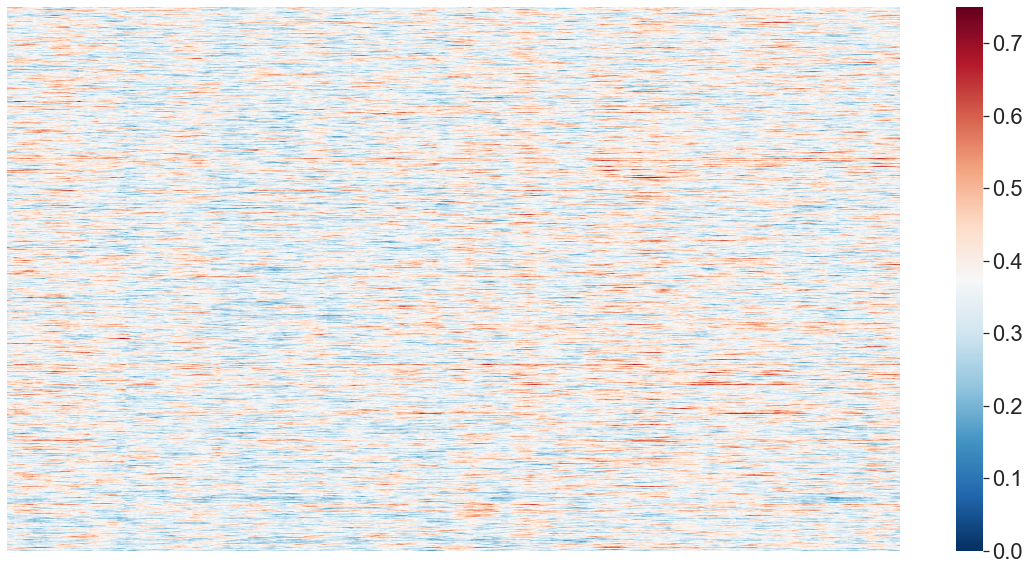

In [101]:
plt.subplots(1,1,figsize=(20,10))
sns.heatmap(tvFC_asis.std(dim='Subject'),cmap='RdBu_r', vmin=0, vmax=0.75, xticklabels=False, yticklabels=False)

<AxesSubplot:>

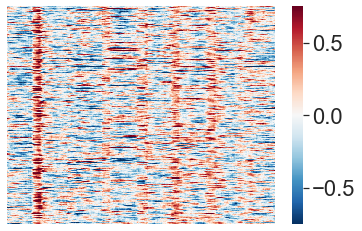

In [93]:
sns.heatmap(tvFC_zscored.mean(dim='Subject'),cmap='RdBu_r', vmin=-0.75, vmax=0.75, xticklabels=False, yticklabels=False)

(array([3.17900000e+03, 3.04611000e+05, 8.51930600e+06, 6.33625120e+07,
        1.08968858e+08, 5.13674820e+07, 8.77166200e+06, 6.60626000e+05,
        2.24730000e+04, 2.51000000e+02]),
 array([-1.9284788 , -1.41198828, -0.89549776, -0.37900724,  0.13748328,
         0.65397379,  1.17046431,  1.68695483,  2.20344535,  2.71993587,
         3.23642639]),
 <BarContainer object of 10 artists>)

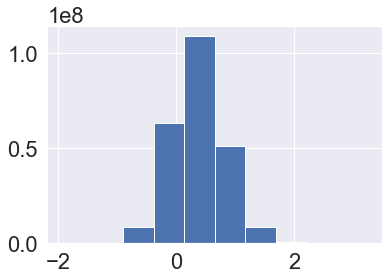

In [96]:
tvFC_asis.plot.hist()

(array([5.7200000e+02, 9.4505000e+04, 3.9181530e+06, 3.8049707e+07,
        9.8708221e+07, 8.0146733e+07, 1.9809115e+07, 1.2367550e+06,
        1.7114000e+04, 8.5000000e+01]),
 array([-5.58117787, -4.42318848, -3.2651991 , -2.10720971, -0.94922033,
         0.20876905,  1.36675844,  2.52474782,  3.68273721,  4.84072659,
         5.99871598]),
 <BarContainer object of 10 artists>)

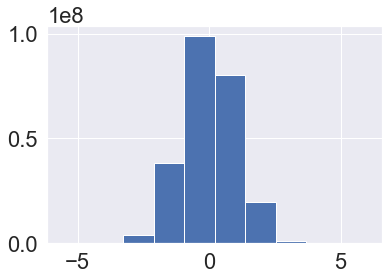

In [97]:
tvFC_zscored.plot.hist()

In [77]:
# For plotting purposes, we need to know what task was being performed during each window. This information is loaded now into the win_labels variable.

# ## 3. Compute Different Matrix Sortings
#
# In Figure 1, we will plot the same tvFC matrix sorting connections in three different ways: 1) in descending order of mean FC, 2) in descencing order of FC volatility (as indexed by the coefficient of variance), and 3) based on hemispheric membership. The next few cells in this section will generate the appropriate indexes with each of these sorting schemes.
#
# First, we do 1) mean and 2) volatility
fig01_resource_folder = osp.join(PRJ_DIR,'Resources','Figure01')

volatility_sorting_idx = (tvFC.std(axis=1)/tvFC.mean(axis=1).abs()).sort_values(ascending=False).index
mean_sorting_idx       = tvFC.mean(axis=1).sort_values(ascending=False).index

# Next, we also compute sorting of connections based on hemispheric membership

ROI_CMs = pd.read_csv(osp.join(fig01_resource_folder,'ROI_Coordinates.txt'), index_col='ROI_ID')

con_info = pd.DataFrame(index=tvFC.index,columns=['Hemi_A','Hemi_B'])
for i,j in tvFC.index:
    if ROI_CMs.loc[i,'x']<0:
        con_info.loc[(i,j),'Hemi_A'] = 'R'
    else:
        con_info.loc[(i,j),'Hemi_A'] = 'L'
    if ROI_CMs.loc[j,'x']<0:
        con_info.loc[(i,j),'Hemi_B'] = 'R'
    else:
        con_info.loc[(i,j),'Hemi_B'] = 'L'

LL_Cons = con_info[(con_info['Hemi_A']=='L') & (con_info['Hemi_B']=='L')].index
RR_Cons = con_info[(con_info['Hemi_A']=='R') & (con_info['Hemi_B']=='R')].index
LR_Cons = con_info[(con_info['Hemi_A']=='L') & (con_info['Hemi_B']=='R')].index
RL_Cons = con_info[(con_info['Hemi_A']=='R') & (con_info['Hemi_B']=='L')].index

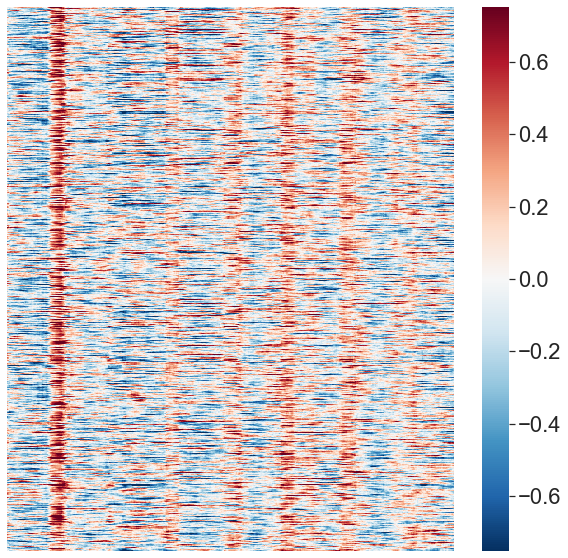

In [80]:
fig,ax = plt.subplots(1,1, figsize=(10,10))
sns.heatmap(pd.concat([tvFC.loc[LL_Cons],tvFC.loc[RR_Cons],tvFC.loc[LR_Cons],tvFC.loc[RL_Cons]]),cmap='RdBu_r', vmin=-0.75, vmax=0.75, xticklabels=False, yticklabels=False)
ax.set(ylabel=None);

The next two cells show the same information as the one above, but in three separate graphs, one per input data type (original, conn rand, phase rand)